# Pipe4: 
## To classify severity of damage - minor, moderate or severe.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import json
from sklearn.metrics import classification_report, confusion_matrix

sns.set_palette("cubehelix")
sns.set_style('whitegrid')

In [26]:
import os
import h5py
import numpy as np
import pandas as pd

import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, l1
from keras.models import Sequential, load_model,Model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from tensorflow.keras import optimizers
from keras.callbacks import ModelCheckpoint, History

In [4]:
def save_bottleneck_features(location):
    datagen = ImageDataGenerator(rescale=1./255)  
    
    model = VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=16,
                                            class_mode=None, 
                                            shuffle=False) 

    bottleneck_features_train = model.predict(generator, nb_train_samples)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)
    
    # repeat with the validation data
    generator = datagen.flow_from_directory(validation_data_dir,
                                           target_size=(img_width, img_height),
                                           batch_size=16,
                                           class_mode=None,
                                           shuffle=False)
    bottleneck_features_validation = model.predict(generator, nb_validation_samples)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

In [5]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print('epoch:', best_epoch+1, \
    ', val_accuracy:', model_hist['val_accuracy'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch])

In [6]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
    
    print("Best Model:") 
    print_best_model_results(hist)

In [7]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='categorical',
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    pred_labels = np.argmax(predictions, axis=1)

    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

In [ ]:
def view_images(img_dir, img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img))
        num = input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

## Defining Input Data

In [8]:
# path to the model weights file
location = '/content/drive/MyDrive/NNDL/Datasets/case_study/data3a'
top_model_weights_path=location+'/top_model_weights' # will be saved into when we create our model
fine_tuned_model_path = location+'/ft_model'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'

train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples)

nb_epoch = 50
batch_size = 16

In [9]:
# do not rerun!
#save_bottleneck_features(location)

58900480/58889256 [==============================] - 0s 0us/step
Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


## Model Parameter Selection

In [10]:
def train_categorical_model1():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1] + 
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (validation_samples[0]) + 
                                 [1] * (validation_samples[1]) +
                                 [2] * (validation_samples[2]))
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizer='rmsprop', 
                  loss='categorical_crossentropy', metrics=['accuracy']) 
    
    checkpoint = ModelCheckpoint(top_model_weights_path+"_1.hdf5", monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history_1.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [11]:
d3_model1, d3_hist1 = train_categorical_model1()

Epoch 1/50
47/62 [=====================>........] - ETA: 0s - loss: 2.7919 - accuracy: 0.4668
Epoch 1: val_accuracy improved from -inf to 0.47368, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data3a/top_model_weights_1.hdf5
62/62 [==============================] - 2s 9ms/step - loss: 2.7703 - accuracy: 0.4668 - val_loss: 2.2481 - val_accuracy: 0.4737
Epoch 2/50
51/62 [=======================>......] - ETA: 0s - loss: 1.3379 - accuracy: 0.6434
Epoch 2: val_accuracy did not improve from 0.47368
62/62 [==============================] - 0s 4ms/step - loss: 1.3139 - accuracy: 0.6558 - val_loss: 6.0574 - val_accuracy: 0.4503
Epoch 3/50
50/62 [=======================>......] - ETA: 0s - loss: 0.9225 - accuracy: 0.7487
Epoch 3: val_accuracy improved from 0.47368 to 0.60819, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data3a/top_model_weights_1.hdf5
62/62 [==============================] - 0s 4ms/step - loss: 0.9066 - accuracy: 0.7528 - val_loss: 1.3940 - 

Best Model:
epoch: 8 , val_accuracy: 0.6374269127845764 , val_loss: 2.1911091804504395


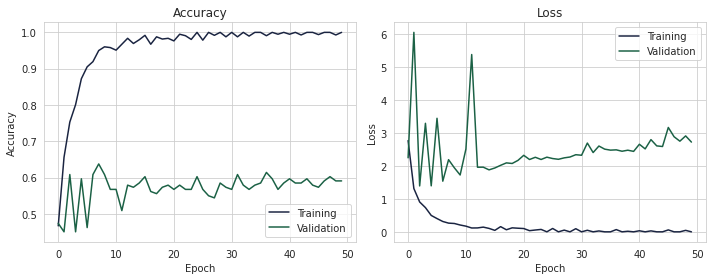

In [12]:
plot_metrics(d3_hist1) # no regularization with 1 dense

In [13]:
def train_categorical_model2():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1] + 
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (validation_samples[0]) + 
                                 [1] * (validation_samples[1]) +
                                 [2] * (validation_samples[2]))
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer='l2'))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizer='rmsprop', 
                  loss='categorical_crossentropy', metrics=['accuracy']) 
    
    checkpoint = ModelCheckpoint(top_model_weights_path+"_2.hdf5", monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history_2.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [14]:
d3_model2, d3_hist2 = train_categorical_model2() # l2 regularization with rmsprop

Epoch 1/50
58/62 [===========================>..] - ETA: 0s - loss: 6.7526 - accuracy: 0.4601
Epoch 1: val_accuracy improved from -inf to 0.35088, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data3a/top_model_weights_2.hdf5
62/62 [==============================] - 1s 12ms/step - loss: 6.5066 - accuracy: 0.4699 - val_loss: 5.5054 - val_accuracy: 0.3509
Epoch 2/50
57/62 [==========================>...] - ETA: 0s - loss: 3.6194 - accuracy: 0.5482
Epoch 2: val_accuracy improved from 0.35088 to 0.45029, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data3a/top_model_weights_2.hdf5
62/62 [==============================] - 1s 10ms/step - loss: 4.1269 - accuracy: 0.5312 - val_loss: 4.3767 - val_accuracy: 0.4503
Epoch 3/50
57/62 [==========================>...] - ETA: 0s - loss: 5.1867 - accuracy: 0.5735
Epoch 3: val_accuracy improved from 0.45029 to 0.59649, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data3a/top_model_weights_2.hdf5
62/62

Best Model:
epoch: 26 , val_accuracy: 0.6374269127845764 , val_loss: 2.0062317848205566


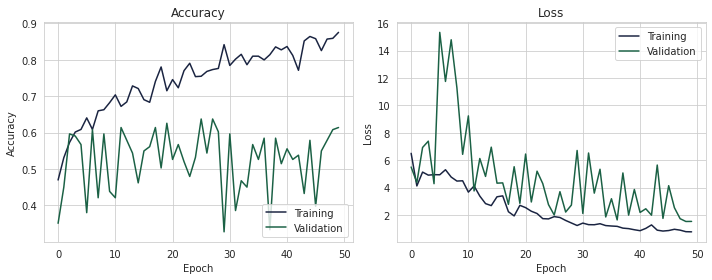

In [15]:
plot_metrics(d3_hist2)

In [16]:
def train_categorical_model3():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1] + 
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (validation_samples[0]) + 
                                 [1] * (validation_samples[1]) +
                                 [2] * (validation_samples[2]))
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizer='rmsprop', 
                  loss='categorical_crossentropy', metrics=['accuracy']) 
    
    checkpoint = ModelCheckpoint(top_model_weights_path+"_3.hdf5", monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history_3.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [17]:
d3_model3, d3_hist3 = train_categorical_model3() # l2 regularization and dropout

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 6.6124 - accuracy: 0.4607
Epoch 1: val_accuracy improved from -inf to 0.28070, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data3a/top_model_weights_3.hdf5
62/62 [==============================] - 1s 12ms/step - loss: 6.6124 - accuracy: 0.4607 - val_loss: 4.5706 - val_accuracy: 0.2807
Epoch 2/50
56/62 [==========================>...] - ETA: 0s - loss: 2.1182 - accuracy: 0.4621
Epoch 2: val_accuracy improved from 0.28070 to 0.32164, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data3a/top_model_weights_3.hdf5
62/62 [==============================] - 1s 10ms/step - loss: 2.1070 - accuracy: 0.4607 - val_loss: 4.7323 - val_accuracy: 0.3216
Epoch 3/50
56/62 [==========================>...] - ETA: 0s - loss: 2.3320 - accuracy: 0.5000
Epoch 3: val_accuracy improved from 0.32164 to 0.46199, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data3a/top_model_weights_3.hdf5
62/62

Best Model:
epoch: 30 , val_accuracy: 0.6725146174430847 , val_loss: 1.229400396347046


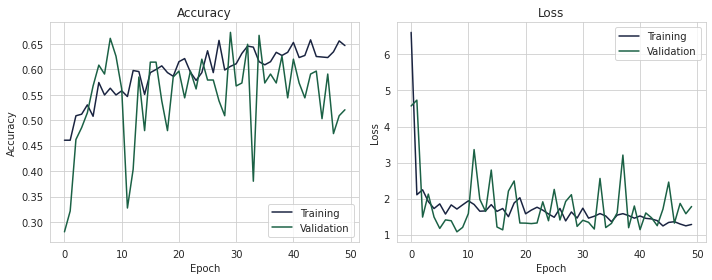

In [18]:
plot_metrics(d3_hist3)

In [19]:
def train_categorical_model4():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1] + 
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (validation_samples[0]) + 
                                 [1] * (validation_samples[1]) +
                                 [2] * (validation_samples[2]))
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer='l2'))
    model.add(Dropout(0.75))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizer='rmsprop', 
                  loss='categorical_crossentropy', metrics=['accuracy']) 
    
    checkpoint = ModelCheckpoint(top_model_weights_path+"_4.hdf5", monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history_4.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [20]:
d3_model4, d3_hist4 = train_categorical_model4() # l2 regularization and aggresive dropout

Epoch 1/50
56/62 [==========================>...] - ETA: 0s - loss: 5.4890 - accuracy: 0.3817
Epoch 1: val_accuracy improved from -inf to 0.60234, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data3a/top_model_weights_4.hdf5
62/62 [==============================] - 1s 12ms/step - loss: 5.1688 - accuracy: 0.3902 - val_loss: 1.5182 - val_accuracy: 0.6023
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 1.6858 - accuracy: 0.4392
Epoch 2: val_accuracy did not improve from 0.60234
62/62 [==============================] - 1s 9ms/step - loss: 1.6858 - accuracy: 0.4392 - val_loss: 1.7474 - val_accuracy: 0.4327
Epoch 3/50
56/62 [==========================>...] - ETA: 0s - loss: 2.5824 - accuracy: 0.4062
Epoch 3: val_accuracy did not improve from 0.60234
62/62 [==============================] - 1s 8ms/step - loss: 2.5448 - accuracy: 0.4106 - val_loss: 1.7940 - val_accuracy: 0.4327
Epoch 4/50
57/62 [==========================>...] - ETA: 0s - loss: 1.7342 - ac

Best Model:
epoch: 19 , val_accuracy: 0.6140350699424744 , val_loss: 1.0349608659744263


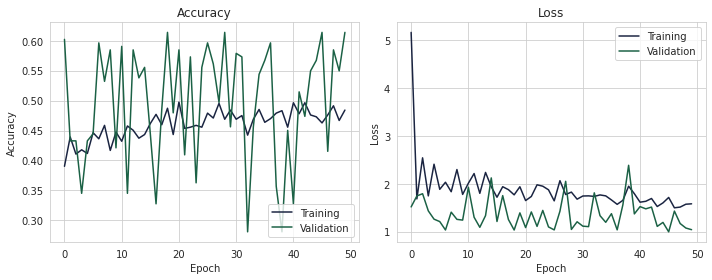

In [21]:
plot_metrics(d3_hist4)

In [22]:
def train_categorical_model5():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1] + 
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (validation_samples[0]) + 
                                 [1] * (validation_samples[1]) +
                                 [2] * (validation_samples[2]))
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])

    
    checkpoint = ModelCheckpoint(top_model_weights_path+"_5.hdf5", monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history_5.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [27]:
d3_model5, d3_hist5 = train_categorical_model5() # dense and dropout layers with l2 regularization and sgd

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


59/62 [===========================>..] - ETA: 0s - loss: 6.3227 - accuracy: 0.3697
Epoch 1: val_accuracy improved from -inf to 0.52047, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data3a/top_model_weights_5.hdf5
62/62 [==============================] - 1s 10ms/step - loss: 6.3155 - accuracy: 0.3708 - val_loss: 6.0573 - val_accuracy: 0.5205
Epoch 2/50
60/62 [============================>.] - ETA: 0s - loss: 6.0464 - accuracy: 0.5042
Epoch 2: val_accuracy improved from 0.52047 to 0.56140, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data3a/top_model_weights_5.hdf5
62/62 [==============================] - 0s 8ms/step - loss: 6.0455 - accuracy: 0.5036 - val_loss: 5.9885 - val_accuracy: 0.5614
Epoch 3/50
60/62 [============================>.] - ETA: 0s - loss: 5.9430 - accuracy: 0.5760
Epoch 3: val_accuracy improved from 0.56140 to 0.62573, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data3a/top_model_weights_5.hdf5
62/62 [==========

Best Model:
epoch: 8 , val_accuracy: 0.6725146174430847 , val_loss: 5.778540134429932


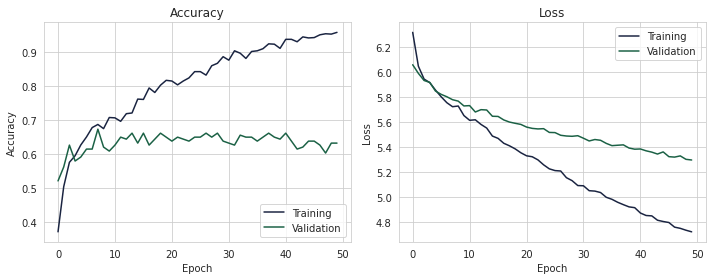

In [28]:
plot_metrics(d3_hist5)

In [29]:
def train_categorical_model6():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1] + 
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (validation_samples[0]) + 
                                 [1] * (validation_samples[1]) +
                                 [2] * (validation_samples[2]))
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation = 'relu',kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])

    
    checkpoint = ModelCheckpoint(top_model_weights_path+"_6.hdf5", monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history_6.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [30]:
d3_model6, d3_hist6 = train_categorical_model6() # double dense and dropout layers with regularization

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


54/62 [=========================>....] - ETA: 0s - loss: 8.0550 - accuracy: 0.3519
Epoch 1: val_accuracy improved from -inf to 0.46784, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data3a/top_model_weights_6.hdf5
62/62 [==============================] - 1s 11ms/step - loss: 8.0360 - accuracy: 0.3565 - val_loss: 7.8459 - val_accuracy: 0.4678
Epoch 2/50
58/62 [===========================>..] - ETA: 0s - loss: 7.8957 - accuracy: 0.3987
Epoch 2: val_accuracy did not improve from 0.46784
62/62 [==============================] - 0s 6ms/step - loss: 7.8959 - accuracy: 0.3922 - val_loss: 7.8459 - val_accuracy: 0.3801
Epoch 3/50
61/62 [============================>.] - ETA: 0s - loss: 7.8295 - accuracy: 0.3934
Epoch 3: val_accuracy did not improve from 0.46784
62/62 [==============================] - 0s 6ms/step - loss: 7.8288 - accuracy: 0.3953 - val_loss: 7.7787 - val_accuracy: 0.4386
Epoch 4/50
60/62 [============================>.] - ETA: 0s - loss: 7.7869 - accuracy: 0.4

Best Model:
epoch: 29 , val_accuracy: 0.6491228342056274 , val_loss: 7.09764289855957


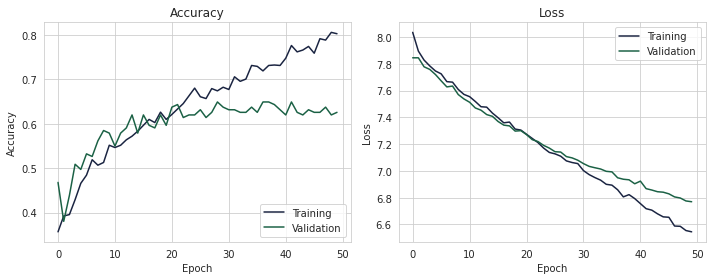

In [31]:
plot_metrics(d3_hist6)

## Finetuning Model

In [33]:
def finetune_categorical_model1():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu',kernel_regularizer='l2'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    top_model.load_weights(top_model_weights_path+"_3.hdf5") 

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    for layer in model.layers[:25]:
        layer.trainable=False

    model.compile(optimizer='rmsprop', 
                  loss='categorical_crossentropy', metrics=['accuracy']) 
    
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=8,
                                                     class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=8,
                                                           class_mode='categorical')
    
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path+"_1.hdf5", monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, 
                                 save_weights_only=False, mode='max')
        
    # fine-tune the model
    fit = model.fit(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=nb_epoch,
                              validation_data=validation_generator,
                              validation_steps = nb_validation_samples//batch_size,
                              verbose=1,
                              callbacks=[checkpoint])
    
    with open(location+'/ft_history_1.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

### Run 1 - With Regularization

In [34]:
ft_d3_model1, ft_d3_hist1 = finetune_categorical_model1()

Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/50
61/61 [==============================] - ETA: 0s - loss: 1.7258 - accuracy: 0.5217
Epoch 1: val_accuracy improved from -inf to 0.66250, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data3a/ft_model.hdf5_1.hdf5
61/61 [==============================] - 12s 159ms/step - loss: 1.7258 - accuracy: 0.5217 - val_loss: 1.2693 - val_accuracy: 0.6625
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 1.6304 - accuracy: 0.5507
Epoch 2: val_accuracy did not improve from 0.66250
61/61 [==============================] - 10s 154ms/step - loss: 1.6304 - accuracy: 0.5507 - val_loss: 1.1635 - val_accuracy: 0.6625
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 1.6700 - accuracy: 0.5259
Epoch 3: val_accuracy did not improve from 0.66250
61/61 [==============================] - 9s 152ms/step - loss: 1.6700 - accuracy: 0.5259 - val_loss: 1.3314 - val_accuracy: 0

Best Model:
epoch: 12 , val_accuracy: 0.7250000238418579 , val_loss: 1.103124976158142


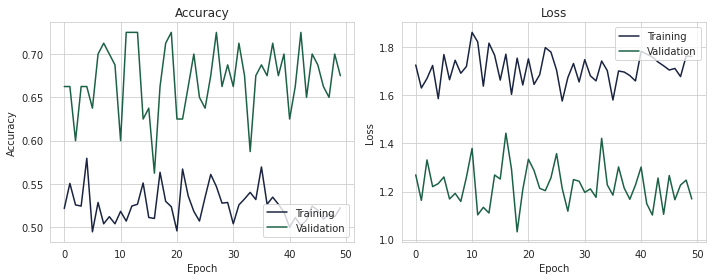

In [35]:
plot_metrics(ft_d3_hist1)

### Run 2 - Without Regularization

In [36]:
def finetune_categorical_model2():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    top_model.load_weights(top_model_weights_path+"_3.hdf5") 

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    for layer in model.layers[:25]:
        layer.trainable=False

    model.compile(optimizer='rmsprop', 
                  loss='categorical_crossentropy', metrics=['accuracy']) 
    
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=8,
                                                     class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=8,
                                                           class_mode='categorical')
    
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path+"_2.hdf5", monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, 
                                 save_weights_only=False, mode='max')
        
    # fine-tune the model
    fit = model.fit(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=nb_epoch,
                              validation_data=validation_generator,
                              validation_steps = nb_validation_samples//batch_size,
                              verbose=1,
                              callbacks=[checkpoint])
    
    with open(location+'/ft_history_2.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [37]:
ft_d3_model2, ft_d3_hist2 = finetune_categorical_model2()

Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/50
61/61 [==============================] - ETA: 0s - loss: 1.4151 - accuracy: 0.5135
Epoch 1: val_accuracy improved from -inf to 0.71250, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data3a/ft_model.hdf5_2.hdf5
61/61 [==============================] - 10s 161ms/step - loss: 1.4151 - accuracy: 0.5135 - val_loss: 0.9333 - val_accuracy: 0.7125
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 1.4914 - accuracy: 0.5082
Epoch 2: val_accuracy did not improve from 0.71250
61/61 [==============================] - 10s 156ms/step - loss: 1.4914 - accuracy: 0.5082 - val_loss: 0.7191 - val_accuracy: 0.7125
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 1.4244 - accuracy: 0.5052
Epoch 3: val_accuracy improved from 0.71250 to 0.75000, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data3a/ft_model.hdf5_2.hdf5
61/61 [=====================

Best Model:
epoch: 48 , val_accuracy: 0.7875000238418579 , val_loss: 0.6920627355575562


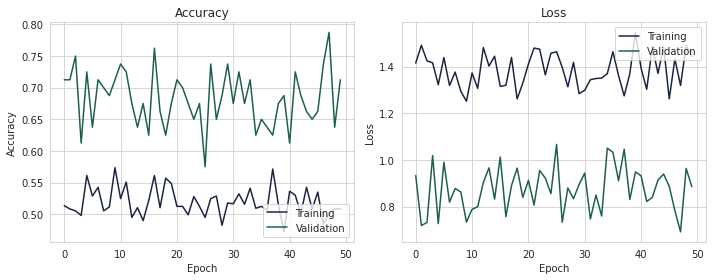

In [38]:
plot_metrics(ft_d3_hist2)

## Model Evaluation

In [43]:
ft_d3_model1 = load_model(location+'/ft_model.hdf5_1.hdf5') # with regularization, first run

In [44]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1] +
                             [2] * validation_samples[2])

In [45]:
evaluate_categorical_model(ft_d3_model1, validation_data_dir, validation_labels) 

Found 171 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.



              precision    recall  f1-score   support

           0       0.77      0.62      0.69        48
           1       0.51      0.71      0.60        55
           2       0.82      0.68      0.74        68

    accuracy                           0.67       171
   macro avg       0.70      0.67      0.68       171
weighted avg       0.71      0.67      0.68       171




array([[30, 15,  3],
       [ 9, 39,  7],
       [ 0, 22, 46]])

In [46]:
ft_d3_model2 = load_model(location+'/ft_model.hdf5_2.hdf5') # without regularization, first run

In [47]:
evaluate_categorical_model(ft_d3_model2, validation_data_dir, validation_labels)

Found 171 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.



              precision    recall  f1-score   support

           0       0.77      0.62      0.69        48
           1       0.51      0.71      0.60        55
           2       0.82      0.68      0.74        68

    accuracy                           0.67       171
   macro avg       0.70      0.67      0.68       171
weighted avg       0.71      0.67      0.68       171




array([[30, 15,  3],
       [ 9, 39,  7],
       [ 0, 22, 46]])

Found 171 images belonging to 3 classes.

             precision    recall  f1-score   support

          0       0.79      0.71      0.75        48
          1       0.53      0.65      0.59        55
          2       0.80      0.71      0.75        68

avg / total       0.71      0.69      0.70       171




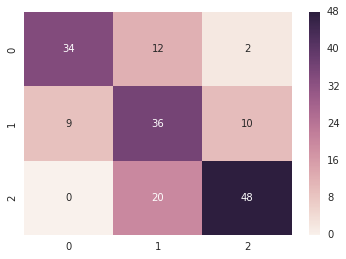

In [ ]:
evaluate_categorical_model(ft_d3_model3, validation_data_dir, validation_labels)

## Load Model Point

In [49]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4,6))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
           
    print("Best Model:") 
    print_best_model_results(hist)

In [50]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='categorical',
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    pred_labels = np.argmax(predictions, axis=1)
    
    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

In [53]:
# WINNER
ft_model = load_model(location+'/ft_model.hdf5_2.hdf5')  # without regularization, second run

In [55]:
with open(location+'/ft_history_2.txt') as f:    
    ft_history = json.load(f)

In [56]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1] +
                             [2] * validation_samples[2])

In [57]:
cm = evaluate_categorical_model(ft_model, validation_data_dir, validation_labels)

Found 171 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.



              precision    recall  f1-score   support

           0       0.77      0.62      0.69        48
           1       0.51      0.71      0.60        55
           2       0.82      0.68      0.74        68

    accuracy                           0.67       171
   macro avg       0.70      0.67      0.68       171
weighted avg       0.71      0.67      0.68       171




In [62]:
with open(location+'/top_history_3.txt') as f:    
    top_history = json.load(f)

def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,7))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist1['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist2['accuracy'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_accuracy'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')
                             
    plt.tight_layout();

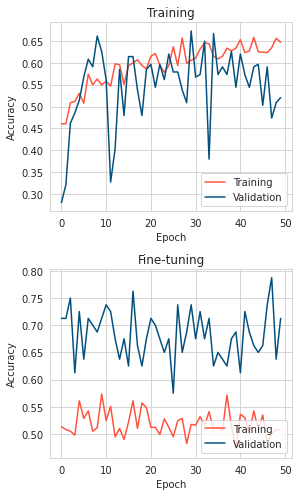

In [63]:
plot_acc_metrics(top_history, ft_history)

In [64]:
heatmap_labels = ['Minor', 'Moderate', 'Severe']

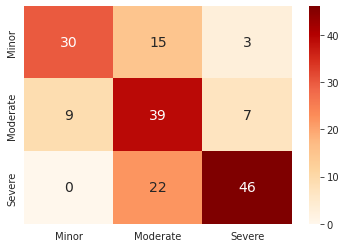

In [65]:
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

## Making Live Predictions

In [69]:
from urllib.request import urlretrieve
def severity_estimator(image_path, model,option=1):
    print("Determining severity of damage...")
    if(option==1):
      urlretrieve(image_path, 'save.jpg') # or other way to upload image
      img = load_img('save.jpg', target_size=(256, 256)) # this is a PIL image
    else:
      img = load_img(image_path,target_size=(256, 256)) 
    x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
    x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
    pred = model.predict(x)
    print(pred)
    pred_label = np.argmax(pred, axis=1)
    d = {0: 'Minor', 1: 'Moderate', 2: 'Severe'}
    for key in d.keys():
        if pred_label[0] == key:
            print("Assessment: {} damage to vehicle".format(d[key]))
    print("Severity assessment complete.")

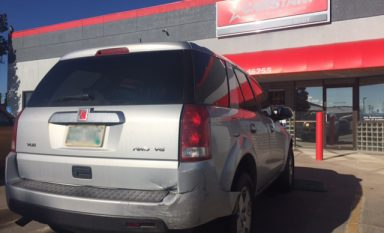

In [67]:
Image('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg')

In [70]:
severity_estimator('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg', ft_model)

Determining severity of damage...
[[0.8650854  0.13280867 0.00210591]]
Assessment: Minor damage to vehicle
Severity assessment complete.


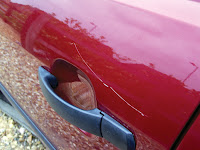

In [71]:
Image('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg')

In [72]:
severity_estimator('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg', ft_model)

Determining severity of damage...
[[0.632437   0.35404634 0.01351669]]
Assessment: Minor damage to vehicle
Severity assessment complete.


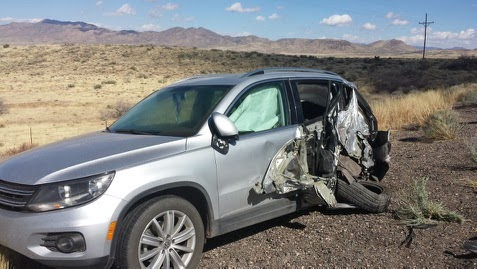

In [73]:
Image('http://1.bp.blogspot.com/-hzoFer11Gcw/Uw_b0Z8HGAI/AAAAAAAAA4M/XjV-NrRl0iM/s1600/20140227_140935.jpg')

In [74]:
severity_estimator('http://1.bp.blogspot.com/-hzoFer11Gcw/Uw_b0Z8HGAI/AAAAAAAAA4M/XjV-NrRl0iM/s1600/20140227_140935.jpg', ft_model)

Determining severity of damage...
[[0.00209389 0.24951664 0.7483895 ]]
Assessment: Severe damage to vehicle
Severity assessment complete.


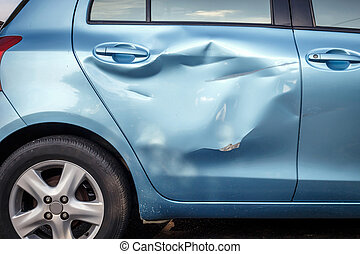

In [75]:
Image('http://cdn.xl.thumbs.canstockphoto.com/canstock23892567.jpg')

In [76]:
severity_estimator('http://cdn.xl.thumbs.canstockphoto.com/canstock23892567.jpg', ft_model)

Determining severity of damage...
[[0.52009124 0.47105852 0.00885027]]
Assessment: Minor damage to vehicle
Severity assessment complete.


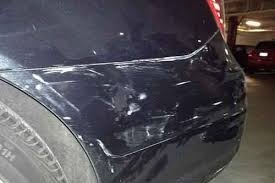

In [78]:
Image(location+'/validation/01-minor/0001.JPEG')

In [80]:
severity_estimator(location+'/validation/01-minor/0001.JPEG', ft_model,option=0)

Determining severity of damage...
[[0.9299616  0.0687429  0.00129553]]
Assessment: Minor damage to vehicle
Severity assessment complete.


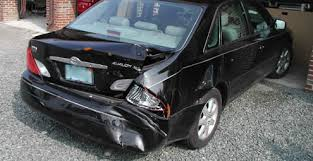

In [82]:
Image(location+'/validation/02-moderate/0002.JPEG')

In [84]:
severity_estimator(location+'/validation/02-moderate/0003.JPEG', ft_model,option=0)

Determining severity of damage...
[[0.05263594 0.7735881  0.17377593]]
Assessment: Moderate damage to vehicle
Severity assessment complete.


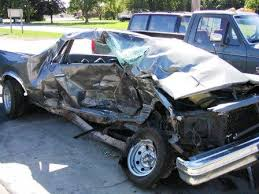

In [85]:
Image(location+'/validation/03-severe/0002.JPEG')

In [86]:
severity_estimator(location+'/validation/03-severe/0002.JPEG', ft_model,option=0)

Determining severity of damage...
[[6.8431611e-05 2.5275659e-02 9.7465593e-01]]
Assessment: Severe damage to vehicle
Severity assessment complete.
